In [1]:
# Import stuff: 
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sympy import Symbol
from sympy.solvers import solve

# This is for reasonable fontsize universally defined:
fs_label = 16
parameters = {                
                'figure.titlesize': fs_label+6,
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.linewidth': 5
             }
plt.rcParams.update(parameters)

In [12]:
# Parameters: 
# TODO: use the real values
params_dict=dict(
    H_P = 10, 
    H_Z = 50, 
    P_0 = 2500, 
    N_0 = 8000, 
    C_max = 20, 
    r = 0.05, # carefull!! extremely sensitive param.
    eps = 0.85, 
    d = 2.5, 
    M = 60, 
    phi = np.pi*47/180, 
    m = 1 #3 #1 #0.3 # carefull!! extremely sensitive param.
)
#params_dict.update(
#    g_val = g(params_dict["t"], params_dict["phi"], params_dict["M"])
#)

for k, v in params_dict.items():
    assign_str = f"{k} = {v}"
    exec(assign_str)
    print(assign_str)

    # phi is the azimuthal angle in radians, s.t. 0 <= phi <= pi

g = lambda t, phi, M: np.exp(-0.025*M)*(1- 0.8*np.sin(phi)*np.cos(t*(2*np.pi/365)))

uptake = lambda N, g, H_P=H_P, r=r: g*(N/(H_P + N)) - r
grazing = lambda P, P_0=P_0, C_max=C_max, H_Z=H_Z: max(0, C_max*(P-P_0)/(H_Z + (P - P_0)))

# exchange = lambda A, A_0, m=m, M=M: (m/M)*(A_0 - A)


H_P = 10
H_Z = 50
P_0 = 2500
N_0 = 8000
C_max = 20
r = 0.05
eps = 0.85
d = 2.5
M = 60
phi = 0.8203047484373349
m = 1


In [15]:
N_init = int(1e4)
P_init = int(5e3)
Z_init = int(1e3)

state_init = [N_init, P_init, Z_init]

params = tuple(params_dict.items())
def deriv(state, t, *params):
    
    for k, v in params:
        assign_str = f"{k} = {v}"
        exec(assign_str)
    
    N, P, Z = state
    
    Up = uptake(N, g(t, phi, M), H_P=H_P, r=r)
    Gr = grazing(P, P_0=P_0, C_max=C_max, H_Z=H_Z) 
    
    #print(Up, Gr)
    
    dNdt = -Up*P + (m/M)*(N_0 - N) #+ exchange(N, N_0, m=m, M=M)
    dPdt = Up*P - Gr*Z - (m/M)*P # + exchange(P+P_0, P_0, m=m, M=M)
    dZdt = eps*Gr*Z - d*Z
    
    return np.array([dNdt, dPdt, dZdt])

t_list = np.linspace(0, 7000, 10000)
ns = odeint(deriv, state_init, t_list, args=params)



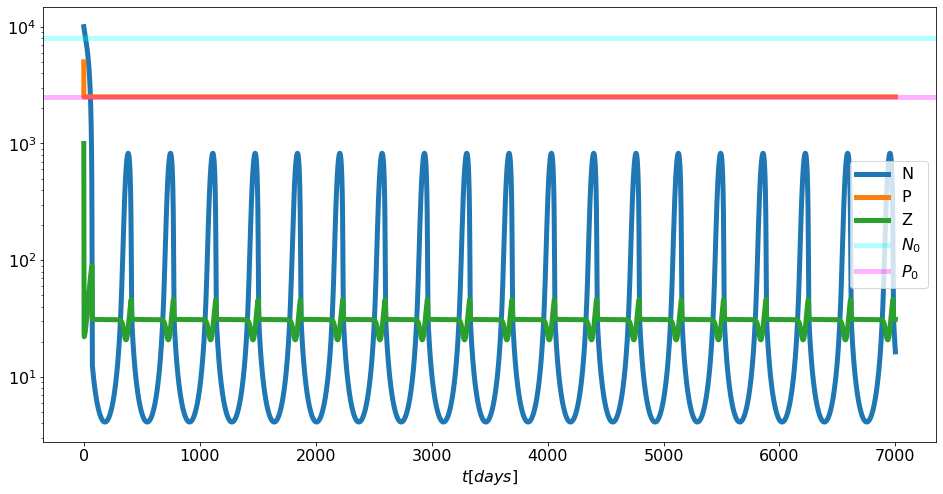

In [17]:
fig, ax = plt.subplots(figsize=(16,8))
lbls = ["N", "P", "Z"]
for i, sol in enumerate(ns.T):
    ax.plot(t_list, sol, label=lbls[i])
    
ax.axhline(N_0, color="cyan", alpha=0.3, label="$N_{0}$")
ax.axhline(P_0, color="Magenta", alpha=0.3, label="$P_{0}$")
ax.set_xlabel("$t [days]$")
ax.set_yscale("log")
ax.legend()

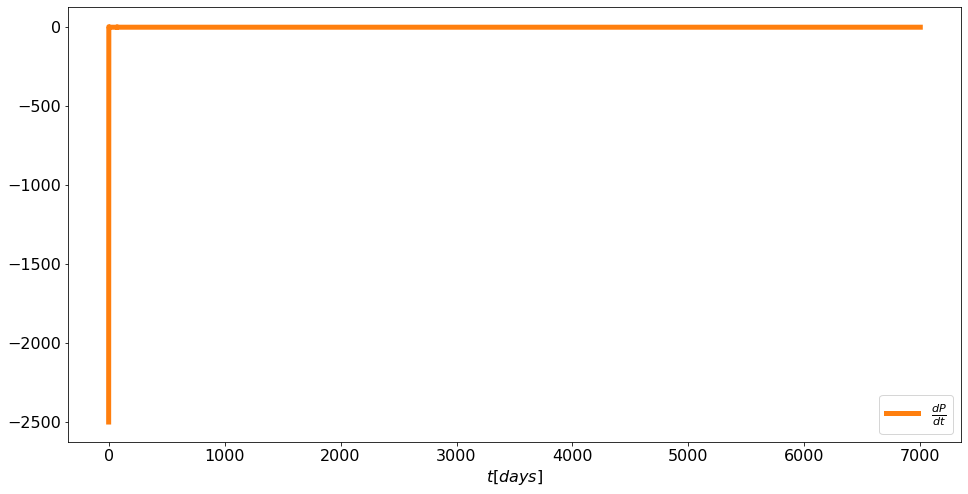

In [18]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(t_list[:-1], np.diff(ns.T[1]), color="tab:orange", label="$\\frac{d P}{d t}$")
ax.set_xlabel("$t [days]$")
ax.legend()